In [12]:
# Basic modules
import pandas as pd
import scipy
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import AutoMinorLocator
from pylab import *
import imageio

# Dimension reduction and clustering libraries
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from scipy.cluster import hierarchy


In [13]:
pd.set_option('display.float_format',lambda X:'%.2f'% X)


In [14]:
# File name which contains the geochemistry data
dfc1 = pd.read_csv('data_122019.csv')
dfc1['Camp'] = 'dry'
dfc2 = pd.read_csv('data_052020.csv')
dfc2['Camp'] = 'normal'
dfc3 = pd.read_csv('data_082020_avg.csv')
dfc3['Camp'] = 'wet'

# Concat these three files
df = pd.concat([dfc1, dfc2, dfc3])

In [15]:
# Check the charge balance error (CBE) using major cations and anions
Ca   = 40
Mg   = 24
K    = 39
Na   = 23
Cl   = 35.5
SO4  = 96
HCO3 = 61
NO3  = 62

CBE_cations = df['Ca'] * 2 / Ca + df['Mg'] * 2 / Mg + df['K'] * 1 / K + df['Na'] * 1 / Na

CBE_anions= df['Cl'] * 1 / Cl + df['SO4'] * 2 / SO4 + df['HCO3_mgL_tit'] * 1/ HCO3 + df['NO3'] * 1 / NO3 
CBE = abs((CBE_cations - CBE_anions) / (CBE_cations + CBE_anions)) * 100

print('--> Number of samples with CBE greater than 10% =', sum(CBE>=10))
df['CBE'] = CBE

df.loc[CBE>=10, ['ID', 'Camp', 'CBE']]

--> Number of samples with CBE greater than 10% = 0


,ID,Camp,CBE


In [16]:
params = ['T','pH', 'TDS', 'DO', 'K', 'Na', 'Ca', 'Mg', 'Cl', 'SO4', 'NO3', 'HCO3_mgL_tit',  'D', 'O18_gy', 'S34', 'O18_jz']
from scipy import stats

for par in params:
    x = df[par].values
    res = stats.shapiro(x)
    print(par, res)


T ShapiroResult(statistic=0.8632865532561945, pvalue=7.504929640249676e-11)
pH ShapiroResult(statistic=0.9791106548182473, pvalue=0.016449266600033936)
TDS ShapiroResult(statistic=0.8277830717870249, pvalue=2.1003790387094045e-12)
DO ShapiroResult(statistic=0.9407362640147875, pvalue=3.32643657323167e-06)
K ShapiroResult(statistic=0.8011545084038291, pvalue=1.9760612863010806e-13)
Na ShapiroResult(statistic=0.8520735212538834, pvalue=2.281682991405147e-11)
Ca ShapiroResult(statistic=0.7981272913947077, pvalue=1.532063519751482e-13)
Mg ShapiroResult(statistic=0.8190878335388903, pvalue=9.456995023560669e-13)
Cl ShapiroResult(statistic=0.862427010552349, pvalue=6.83492063922444e-11)
SO4 ShapiroResult(statistic=0.9104896774738205, pvalue=2.6316103641804324e-08)
NO3 ShapiroResult(statistic=0.4845236561763915, pvalue=2.1861815090743804e-21)
HCO3_mgL_tit ShapiroResult(statistic=0.8750972901504519, pvalue=2.826408808259524e-10)
D ShapiroResult(statistic=0.9831160496580588, pvalue=0.0495482006

In [17]:
df_input = df[df['Type']=='SW'][['pH', 'TDS', 'DO', 'K', 'Na', 'Ca', 'Mg', 'Cl', 'SO4', 'NO3', 'HCO3_mgL_tit', 'S34', 'O18_jz', 'O18_gy', 'D']]

In [18]:
df_input_sw = df_input[['pH', 'TDS', 'DO', 'K', 'Na', 'Ca', 'Mg', 'Cl', 'SO4', 'NO3', 'HCO3_mgL_tit', 'S34', 'O18_jz', 'O18_gy', 'D']]

In [19]:
R1 = np.corrcoef(df_input_sw.values.T)

In [20]:
def kmo(dataset_corr):
    corr_inv = np.linalg.inv(dataset_corr)
    nrow_inv_corr, ncol_inv_corr = dataset_corr.shape
    A = np.ones((nrow_inv_corr,ncol_inv_corr))
    for i in range(0,nrow_inv_corr,1):
        for j in range(i,ncol_inv_corr,1):
            A[i,j] = -(corr_inv[i,j])/(math.sqrt(corr_inv[i,i]*corr_inv[j,j]))
            A[j,i] = A[i,j]
    dataset_corr = np.asarray(dataset_corr)
    kmo_num = np.sum(np.square(dataset_corr)) - np.sum(np.square(np.diagonal(A)))
    kmo_denom = kmo_num + np.sum(np.square(A)) - np.sum(np.square(np.diagonal(A)))
    kmo_value = kmo_num / kmo_denom
    return kmo_value

kmo(R1)

0.6700711716143897

In [21]:
import scipy.stats as stats 
test_statistic, p_value = stats.bartlett(df_input_sw['pH'].values, 
                                         df_input_sw['TDS'].values,
                                         df_input_sw['DO'].values,
                                         df_input_sw['K'].values,
                                         df_input_sw['Na'].values,
                                         df_input_sw['Ca'].values,
                                         df_input_sw['Mg'].values,
                                         df_input_sw['Cl'].values,
                                         df_input_sw['SO4'].values,
                                         df_input_sw['NO3'].values,
                                         df_input_sw['HCO3_mgL_tit'].values,
                                         df_input_sw['S34'].values,
                                         df_input_sw['O18_jz'].values,
                                         df_input_sw['O18_gy'].values,
                                         df_input_sw['D'].values
                                        ) 

In [22]:
# Nature log transformation except for four isotopes
X_df = np.log(df_input_sw)

X_df['S34'] = df_input_sw['S34']
X_df['O18_jz'] = df_input_sw['O18_jz']
X_df['O18_gy'] = df_input_sw['O18_gy']
X_df['D'] = df_input_sw['D']
#X_df.to_csv('X_df.csv')

C:\Users\Jing\anaconda3\lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


In [23]:
# Standardization 
X = X_df.values
rescaledX = StandardScaler().fit_transform(X)

rescaledX

array([[ 0.71782815, -0.63137311,  0.80517584, ..., -0.31426137,
         1.30948174,  1.21077083],
       [ 0.45176356, -1.70755899,  0.59057834, ..., -0.10710644,
         1.81979067,  1.8841904 ],
       [ 0.76583206,  0.28799127, -0.016054  , ..., -0.23657828,
         0.67159559,  0.53735127],
       ...,
       [ 0.30515799,  0.67592087, -0.73418133, ..., -0.36605011,
        -1.3058515 , -1.29050183],
       [ 0.30515799,  0.76841392,  0.13206202, ..., -0.39194447,
        -1.17827427, -1.19429904],
       [ 1.72575659,  0.80890476,  0.84116903, ..., -0.49552194,
        -1.17827427, -1.29050183]])

In [24]:
# Perform PCA analysis
n_parameters = rescaledX.shape[1]
from sklearn.decomposition import PCA
pca = PCA(n_components=n_parameters, svd_solver='full').fit(rescaledX)
X_pca = pca.fit_transform(rescaledX)

pca.explained_variance_

array([6.51672575, 3.02245264, 1.44134729, 1.33912919, 0.84989801,
       0.56609248, 0.46642937, 0.35164463, 0.24430164, 0.10828114,
       0.08875892, 0.06388955, 0.04705775, 0.00885408, 0.00808839])

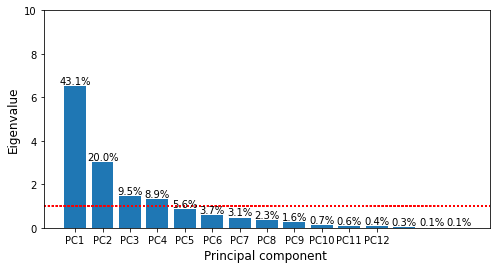

In [35]:
# Plot the explained variance
plt.figure(figsize=(8, 4))
plt.bar([str(i) for i in range(0, n_parameters)], pca.explained_variance_)
# plt.axhline(y=1, color='grey', linestyle='-.')

plt.xlabel('Principal component ', fontsize=12)
plt.ylabel('Eigenvalue', fontsize=12)
#plt.title('Explained variance', fontsize=12)

# Attach explained variance ratio above each bar
for i in range(n_parameters):
    height = pca.explained_variance_[i]
    plt.annotate('{:.1f}%'.format(pca.explained_variance_ratio_[i] * 100),
                 xy=(i, height),
                 xytext=(0, 0),  
                 textcoords="offset points",
                 ha='center', va='bottom', 
                 rotation=0, fontsize=10)
    
    plt.axhline(y=1, color='r', linestyle=':')
plt.ylim([0, 10])
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], 
           ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12'], fontsize=10)
plt.show()

In [26]:
col_names = ['pH', 'TDS', 'DO', 'K', 'Na', 'Ca', 'Mg', 'Cl', 'SO4', 'NO3', 'HCO3_mgL_tit', 'S34', 'O18_jz', 'O18_gy', 'D']

X_pcadf = pd.DataFrame(pca.components_, columns=col_names)


X_pcadf.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
pH,0.06,0.28,0.45,-0.41,-0.40,0.03,0.08,0.26,-0.46,-0.19,0.12,0.15,0.15,-0.02,0.01
TDS,0.35,-0.04,0.14,0.13,-0.22,-0.04,-0.16,0.34,-0.13,0.64,-0.32,-0.25,-0.24,0.03,0.04
DO,0.09,0.37,0.33,-0.42,0.05,-0.05,0.24,-0.35,0.54,0.19,-0.16,-0.11,-0.14,-0.01,-0.04
K,0.33,-0.15,-0.21,-0.26,-0.04,0.12,-0.17,-0.23,-0.03,0.04,-0.30,-0.16,0.74,-0.05,-0.02
Na,0.37,-0.05,-0.15,-0.11,-0.08,0.10,-0.11,-0.08,0.05,-0.18,-0.14,0.41,-0.24,0.72,-0.03
Ca,0.24,0.01,0.38,0.43,0.19,-0.37,0.23,0.22,0.23,0.03,0.07,0.25,0.44,0.16,-0.01
Mg,0.37,-0.05,-0.04,0.06,-0.16,0.08,0.14,-0.13,0.03,-0.02,0.69,-0.51,-0.01,0.20,-0.01
Cl,0.37,-0.05,-0.10,-0.03,-0.07,0.17,-0.09,-0.11,0.11,0.25,0.34,0.57,-0.09,-0.51,0.10
SO4,0.35,0.08,0.03,0.02,0.12,0.19,-0.20,0.44,0.33,-0.56,-0.16,-0.21,-0.14,-0.28,-0.01
NO3,0.21,-0.05,0.10,-0.33,0.75,-0.27,-0.20,-0.01,-0.36,0.05,0.14,-0.06,-0.13,0.00,-0.01


In [37]:
from factor_analyzer import FactorAnalyzer

# fit factor analyzer with principal components and varimax rotation
fa = FactorAnalyzer(rotation="varimax", n_factors=4, method='principal')
fa.fit(rescaledX)

# get the rotated factor pattern
loadings2 = pd.DataFrame(fa.loadings_, index=col_names, columns=[f"Factor{i+1}" for i in range(4)])


# display the results
loadings2

,Factor1,Factor2,Factor3,Factor4
pH,0.02,0.07,0.12,0.87
TDS,0.86,-0.03,0.32,0.07
DO,0.07,0.27,0.07,0.87
K,0.91,-0.01,-0.32,0.03
Na,0.97,0.13,-0.09,0.05
Ca,0.54,-0.11,0.72,0.02
Mg,0.94,0.07,0.13,0.01
Cl,0.96,0.10,0.01,0.03
SO4,0.84,0.19,0.20,0.18
NO3,0.53,-0.12,-0.16,0.35
